<a href="https://colab.research.google.com/github/binmosa/GAN_normal_scene/blob/master/new_exper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare the row image datasets

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd "drive/My Drive/01_experiments"

/content/drive/My Drive/01_experiments


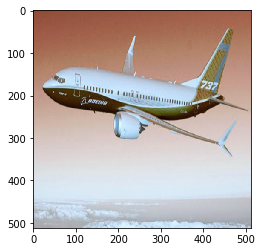

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "mydataset"

CATEGORIES = ["normals"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array)  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [0]:
print(img_array)

In [0]:
print(img_array.shape)

(512, 512, 3)


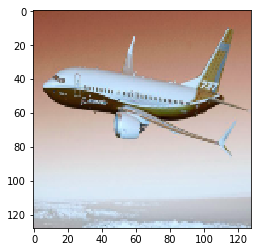

In [0]:
IMG_SIZE = 128

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

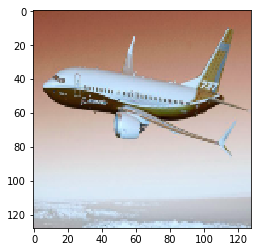

In [0]:
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [0]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=normals

        for img in tqdm(os.listdir(path)):  # iterate over each image per class
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array   ,cv2.IMREAD_GRAYSCALE
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 21/21 [00:12<00:00,  1.83it/s]

21


In [0]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

# X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

X = np.array(X).reshape(-1, 128, 128, 1).astype('float32')   # train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [0]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [0]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

# Setup GANs 

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [0]:
# To generate GIFs
!pip install -q imageio

In [0]:
pip install tensorboardcolab

In [0]:
from tensorboardcolab import TensorBoardColab

Using TensorFlow backend.


In [0]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://795f33c3.ngrok.io


In [0]:
summary_writer = tf.contrib.summary.create_file_writer("Graphs", flush_millis=10000)
summary_writer.set_as_default()
summary_writer = tbc.get_writer()
global_step = tf.train.get_or_create_global_step()

In [0]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [0]:
(train_images, train_labels) = (X, y)

In [0]:
train_images = train_images.reshape(train_images.shape[0], 128, 128, 1).astype('float32')

In [0]:
train_images[0]

In [0]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
train_images[2]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Build Generator

In [0]:
# the generator is compareable to discriminator but in Reverse way
# I have to design the architechter in differnt layers to reach the resultion of 128 * 128
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512) # Note: None is the batch size
    
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    # for the last layer, make it : layers.Conv2DTranspose(3, for color and 1 for gray image
    # same for the output shape
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)
    
    
    return model

Use the (as yet untrained) generator to create an image.

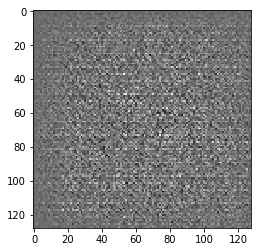

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# The Discriminator

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    

    return model

In [0]:
# Use the (as yet untrained) discriminator to classify the generated images
# as real or fake. The model will be trained to output positive values
# for real images, and negative values for fake images.

discriminator = make_discriminator_model()
decision = discriminator(generated_image)

print (decision)

tf.Tensor([[-0.00028287]], shape=(1, 1), dtype=float32)


Define the loss and optimizers

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator loss

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# The discriminator and the generator optimizers are different since we will train two networks separately.

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

In [0]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Define Training Loop

In [0]:
EPOCHS = 8
noise_dim = 100
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    train_loss(gen_loss)
     
  
  
    global_step.assign_add(1)
    
   # tf.summary.scalar("accuracy", train_accuracy)
    with tf.contrib.summary.always_record_summaries():
        tf.contrib.summary.scalar("loss", gen_loss)
        tf.contrib.summary.scalar("loss", disc_loss)

    #m.update_state(gen_loss, disc_loss)
    

    
    
  # Update the metrics
  
  

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
      

   # with summary_writer.as_default():
  #    tf.summary.scalar('loss', train_loss.result())
    #  tf.summary.scalar('accuracy', train_accuracy.result())
    
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 100 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
 

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5,  cmap='gray')
      plt.axis('off')

  plt.savefig('results/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Train the model

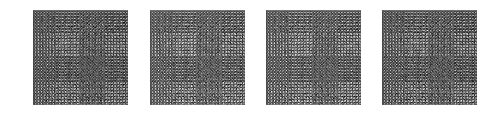

Time for epoch 1 is 16.105702877044678 sec


KeyboardInterrupt: ignored

In [0]:
%%time
train(train_dataset, EPOCHS)

# Greate a Gift

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('results_01exp/image_at_epoch_{:04d}.png'.format(epoch_no))

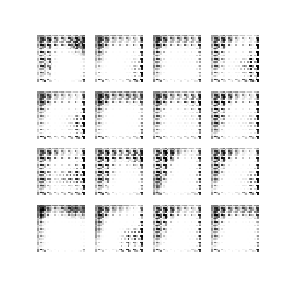

In [0]:
display_image(EPOCHS)


In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filenames)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

OSError: ignored